In [8]:
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from misc.Datamodule import DataModule
from misc.load_model import load_model
from misc.figure_utils import compare_with_data, compare_k_preds, k_integral
import seaborn as sns
sns.set_theme()

results_dir='Results'
data_dir='../datasets'
which_spacing='both'

proj_dirs = ['rate_modelling', 'rate_integrating']

h_dim=64
n_layers=8
method=1

P=500
K=0.5 # in units of P
T=0.525


# Rate Modelling
proj_dir = proj_dirs[0]
rate_dm = DataModule(method, proj_dir, data_dir, results_dir, which_spacing)
rate_model = load_model(method, h_dim, n_layers, proj_dir, rate_dm, saved=True, results_dir=results_dir)

# Rate Integrating
t=20.0
a=0.01
b=0.99
N_pts=50

proj_dir = proj_dirs[1]
int_dm = DataModule(method, proj_dir, data_dir, results_dir, which_spacing)
int_model = load_model(method, h_dim, n_layers, proj_dir, int_dm, saved=True, results_dir=results_dir)


Lightning automatically upgraded your loaded checkpoint from v1.7.7 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file Results/rate_modelling/saved_models/Method_1/M_1_n_layers_8_hid_dim_64_val_pc_err=2.50e-02.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.7.7 to v2.0.7. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file Results/rate_integrating/saved_models/Method_1/M_1_n_layers_8_hid_dim_64_val_pc_err=2.71e-02.ckpt`



        Loading rate_modelling Model 1 with 2.500000%
        

        Loading rate_integrating Model 1 with 2.710000%
        


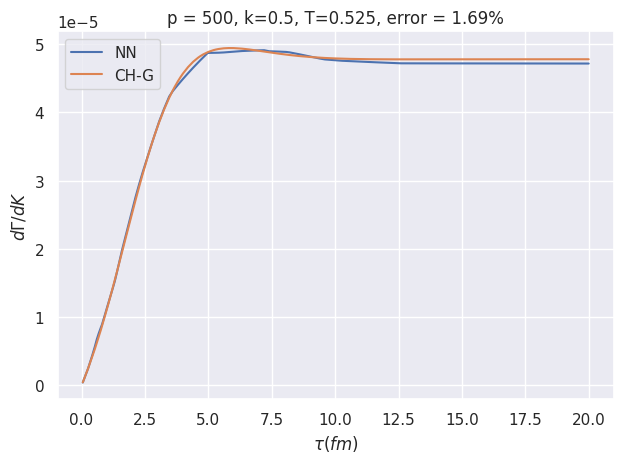

In [6]:
include_data=True
ts, pred_t, data_t = compare_with_data(P, K, T, data_dir, method, rate_model, include_data=include_data)
fig, axs = plt.subplots(1, 1)
axs.plot(ts, pred_t, label='NN')
axs.set_xlabel(r'$\tau (fm)$')
axs.set_ylabel(r'$d \Gamma / dK$')
if data_t is not None:
    axs.plot(ts, data_t, label='CH-G')
    err = ((pred_t-data_t)/data_t).abs().mean()*100
    axs.set_title(f'p = {P}, k={K}, T={T}, error = {err:.2f}%')
else:
    axs.set_title(f'p = {P}, k={K}, T={T}')
plt.tight_layout()
plt.legend()
plt.show()



Simpson integral on data: 0.172644
Gaussian Quad integral on rate model: 0.158849, error = 7.990356%
Integrating Model integral trained on Gaussian Quad on rate model: 0.167361, error = 3.059869%



/home/rodrigo/Desktop/McGill/Research/Rates/rate_modelling/.venv/lib/python3.11/site-packages/scipy/integrate/_quadrature.py:370: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.329462e-05
  warnings.warn(


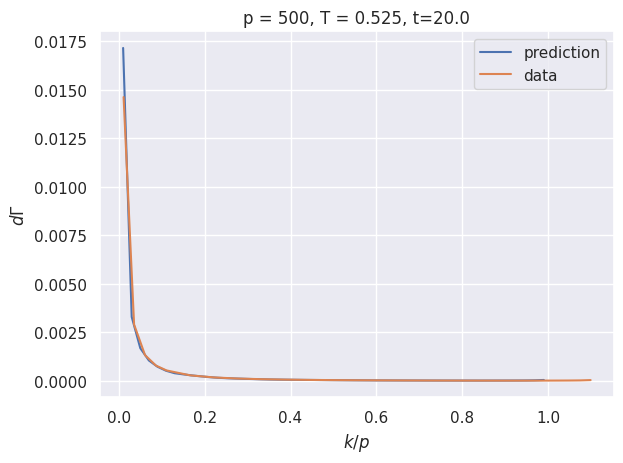

In [7]:
(pred_k, pred_k_gam), (data_k, data_k_gam) = compare_k_preds(P, T, t, data_dir, method, rate_model, a, b, N=N_pts, which=which_spacing)
simp_int_data, simp_int_model = k_integral(P, T, t, data_dir, method, rate_model, a, b, N=N_pts, which=which_spacing)
model_int_model = int_model(torch.tensor([[P, T, t]])).detach().squeeze().numpy()


print(f"""
Simpson integral on data: {simp_int_data:2f}
Gaussian Quad integral on rate model: {simp_int_model[0]:2f}, error = {np.abs((simp_int_model[0]-simp_int_data)/simp_int_data)*100:2f}%
Integrating Model integral trained on Gaussian Quad on rate model: {model_int_model:2f}, error = {np.abs((model_int_model-simp_int_data)/simp_int_data)*100:2f}%
""")

fig, axs = plt.subplots(1, 1)
axs.set_title(f'p = {P}, T = {T}, t={t}')
axs.set_ylabel(r'$d \Gamma$')
axs.plot(pred_k/P, pred_k_gam, label='prediction')
axs.plot(data_k/P, data_k_gam, label='data')
axs.set_xlabel(rf'$k/p$')
# axs.set_xlim(0,1)
plt.tight_layout()
plt.legend()
plt.show()


In [4]:
# Meta plots
# y = Gamma, x1 = P, x2 = T, x3=t
